# About

This notebook demonstrates stacking machine learning algorithm - folding, which physicists use in their analysis.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Loading data

### download particle identification Data Set from UCI

In [2]:
!cd toy_datasets; wget -O MiniBooNE_PID.txt -nc MiniBooNE_PID.txt https://archive.ics.uci.edu/ml/machine-learning-databases/00199/MiniBooNE_PID.txt

File `MiniBooNE_PID.txt' already there; not retrieving.


In [3]:
import numpy, pandas
from rep.utils import train_test_split
from sklearn.metrics import roc_auc_score

data = pandas.read_csv('toy_datasets/MiniBooNE_PID.txt', sep='\s*', skiprows=[0], header=None, engine='python')
labels = pandas.read_csv('toy_datasets/MiniBooNE_PID.txt', sep=' ', nrows=1, header=None)
labels = [1] * labels[1].values[0] + [0] * labels[2].values[0]
data.columns = ['feature_{}'.format(key) for key in data.columns]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=0.5)

# Training variables

In [4]:
variables = list(data.columns)

# Folding strategy - stacking algorithm

It implements the same interface as all classifiers, but with some difference:

* all prediction methods have additional parameter "vote\_function" (example folder.predict(X, __vote\_function=None)__), which is used to combine all classifiers' predictions. By default "mean" is used as "vote_function"

In [5]:
from rep.estimators import SklearnClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Define folding model

In [6]:
from rep.metaml import FoldingClassifier

In [7]:
n_folds = 4
folder = FoldingClassifier(GradientBoostingClassifier(), n_folds=n_folds, features=variables)
folder.fit(train_data, train_labels)

FoldingClassifier(base_estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
         features=['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'featu...', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49'],
         ipc_profile=None, n_folds=4, random_state=None)

## Default prediction (predict i_th_ fold by i_th_ classifier)

In [8]:
folder.predict_proba(train_data)

KFold prediction using folds column


array([[ 0.30859663,  0.69140337],
       [ 0.05812711,  0.94187289],
       [ 0.99080079,  0.00919921],
       ..., 
       [ 0.99125328,  0.00874672],
       [ 0.99076659,  0.00923341],
       [ 0.48643012,  0.51356988]])

## Voting prediction (predict i-fold by all classifiers and take value, which is calculated by `vote_function`)

In [9]:
# definition of mean function, which combines all predictions
def mean_vote(x):
    return numpy.mean(x, axis=0)

In [10]:
folder.predict_proba(test_data, vote_function=mean_vote)

KFold prediction with voting function


array([[ 0.97647592,  0.02352408],
       [ 0.66515219,  0.33484781],
       [ 0.08472414,  0.91527586],
       ..., 
       [ 0.97104092,  0.02895908],
       [ 0.99183086,  0.00816914],
       [ 0.77200234,  0.22799766]])

# Comparison of folds

Again use `ClassificationReport` class to compare different results. For folding classifier this report uses only __default prediction__.

## Report training dataset

In [12]:
from rep.data.storage import LabeledDataStorage
from rep.report import ClassificationReport
# add folds_column to dataset to use mask
train_data["FOLDS"] = folder._get_folds_column(len(train_data))
lds = LabeledDataStorage(train_data, train_labels)

report = ClassificationReport({'folding': folder}, lds)

KFold prediction using folds column


/Users/antares/.virtualenvs/rep_open/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Signal distribution for each fold

Use `mask` parameter to plot distribution for the specific fold 

/Users/antares/.virtualenvs/rep_open/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


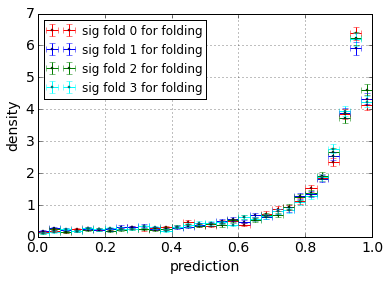

In [13]:
for fold_num in range(n_folds):
    report.prediction_pdf(mask="FOLDS == %d" % fold_num, labels_dict={1: 'sig fold %d' % fold_num}).plot()

### Background distribution for each fold

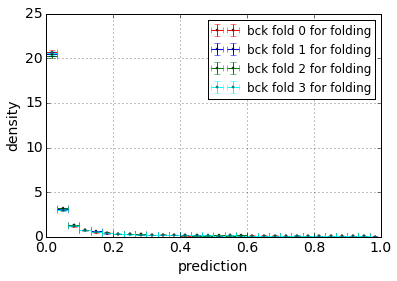

In [14]:
for fold_num in range(n_folds):
    report.prediction_pdf(mask="FOLDS == %d" % fold_num, labels_dict={0: 'bck fold %d' % fold_num}).plot()

### ROCs (each fold used as test dataset)

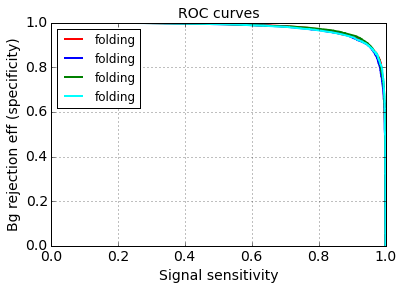

In [15]:
for fold_num in range(n_folds):
    report.roc(mask="FOLDS == %d" % fold_num).plot()

## Report for test dataset 

__NOTE__: Here vote function is None, so default prediction is used

In [16]:
lds = LabeledDataStorage(test_data, test_labels)

report = ClassificationReport({'folding': folder}, lds)

KFold prediction using folds column


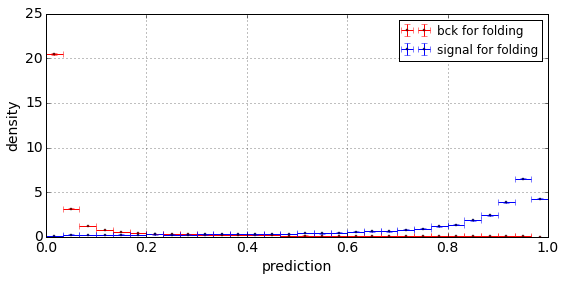

In [17]:
report.prediction_pdf().plot(new_plot=True, figsize = (9, 4))

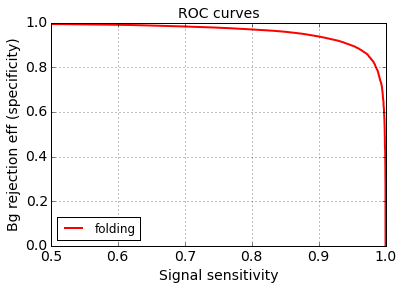

In [18]:
report.roc().plot(xlim=(0.5, 1))